## 1. Preparação dos dados

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


### 1.1 Limpeza

In [2]:
#Carregando os dados e verificando sua integridade
train_data = pd.read_csv("treino.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   inadimplente                           110000 non-null  int64  
 1   util_linhas_inseguras                  110000 non-null  float64
 2   idade                                  110000 non-null  int64  
 3   vezes_passou_de_30_59_dias             110000 non-null  int64  
 4   razao_debito                           110000 non-null  float64
 5   salario_mensal                         88237 non-null   float64
 6   numero_linhas_crdto_aberto             110000 non-null  int64  
 7   numero_vezes_passou_90_dias            110000 non-null  int64  
 8   numero_emprestimos_imobiliarios        110000 non-null  int64  
 9   numero_de_vezes_que_passou_60_89_dias  110000 non-null  int64  
 10  numero_de_dependentes                  107122 non-null  

Existem poucos dados faltantes na coluna número de dependentes, menos de 3% do total. 
Por serem poucos, podemos descartar as linhas sem prejuíxo significativo à análise mas por hora é melhor não sobrescrever o dataframe.

Já na coluna *salario_mensal* temos um grande número de valores nulos. Nesse caso pode-se ignorar os salários completamente ou desconsiderar os clientes com salários não informados. Testaremos as duas estratégias.

## 1.2 Manipulação

Três colunas parecem estar ligadas: *numero_vezes_passou_90_dias, numero_de_vezes_que_passou_60_89_dias* e *vezes_passou_de_30_59_dias*. Pode-se verificar ordenando o banco de dados por um desses atributos e observando os valores mais altos

In [3]:
train_data.sort_values("numero_vezes_passou_90_dias", ascending = False).head(20)

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
21374,0,1.0,37,98,0.000000,NaN,0,98,0,98,0.0
77887,1,1.0,37,98,0.000000,6000.0,0,98,0,98,1.0
12131,1,1.0,50,98,0.000000,1350.0,0,98,0,98,0.0
45814,1,1.0,50,98,0.000000,NaN,0,98,0,98,0.0
98603,0,1.0,52,98,0.000000,9016.0,0,98,0,98,2.0
38540,0,1.0,65,98,0.125475,525.0,0,98,0,98,0.0
62906,1,1.0,47,98,0.000000,600.0,0,98,0,98,0.0
42751,0,1.0,22,98,0.000000,201.0,0,98,0,98,0.0
28291,0,1.0,45,98,0.000000,2950.0,0,98,0,98,2.0
23915,1,1.0,65,98,0.012215,1800.0,0,98,0,98,0.0


Pode-se ver acima que as três colunas com informação sobre inadimplências do passado possuem uma certa dependência: Cada divida que passou dos 90 dias, também é contabilizada nas colunas 30-59 e 60-89.

Isso não é necessariamente ruim, mas para treinar um modelo de Machine Learning é mais sensato eliminar essa dependência.

In [4]:
train_data["numero_de_vezes_que_passou_60_89_dias"]=train_data["numero_de_vezes_que_passou_60_89_dias"]-train_data["numero_vezes_passou_90_dias"]

In [5]:
train_data["vezes_passou_de_30_59_dias"]=train_data["vezes_passou_de_30_59_dias"]-train_data["numero_de_vezes_que_passou_60_89_dias"]

Sobraram apenas os valores nulos. Irei primeiramente eliminar as linhas com valores nulos e testar a acurácia do modelo


In [6]:
train_data_salary = train_data.dropna()
train_data_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88237 entries, 0 to 109999
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   inadimplente                           88237 non-null  int64  
 1   util_linhas_inseguras                  88237 non-null  float64
 2   idade                                  88237 non-null  int64  
 3   vezes_passou_de_30_59_dias             88237 non-null  int64  
 4   razao_debito                           88237 non-null  float64
 5   salario_mensal                         88237 non-null  float64
 6   numero_linhas_crdto_aberto             88237 non-null  int64  
 7   numero_vezes_passou_90_dias            88237 non-null  int64  
 8   numero_emprestimos_imobiliarios        88237 non-null  int64  
 9   numero_de_vezes_que_passou_60_89_dias  88237 non-null  int64  
 10  numero_de_dependentes                  88237 non-null  float64
dtypes

## 2. Modelo

### 2.1 Treinando o modelo

In [14]:
#dividindo os dados em teste (20%) e treino (80%)
train, test, target_train, target_test = train_test_split(
    train_data_salary.drop("inadimplente", axis = 1),
    train_data_salary["inadimplente"],
    test_size = 0.2,
    random_state = 33
)

In [15]:
#como o resultado desejado é uma classificação, usaremos um modelo baseado em arvore de decisão
model1 = DecisionTreeClassifier()

model1 = model1.fit(train, target_train)

### 2.2 Avaliação do modelo

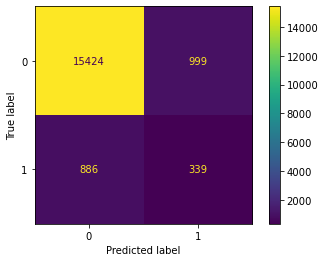

In [16]:
plot_confusion_matrix(model1, test, target_test)
plt.show()

In [17]:
#calculando a acurácia
predicted = model1.predict(test)
matrix = confusion_matrix(target_test, predicted)
acc = round(np.diag(matrix).sum()/matrix.sum(),4)
acc

0.8932

A acurácia deste modelo fica em torno de 89.2% e não está ruim, mas principalmente devido ao grande número de adimplentes no banco de dados. O número de acertos ao prever inadimplentes está bem abaixo dos falsos positivos e dos falsos negativos.

Irei realizar outro teste, desta vez descartando a coluna de salários do dataframe original


## Excluindo os salários

In [18]:
train_data_no_salary = train_data.drop("salario_mensal", axis = 1).dropna()

In [35]:
train, test, target_train, target_test = train_test_split(
    train_data_no_salary.drop("inadimplente", axis = 1),
    train_data_no_salary["inadimplente"],
    test_size = 0.2,
    random_state = 33
)

In [36]:
model2 = DecisionTreeClassifier()

model2 = model2.fit(train, target_train)

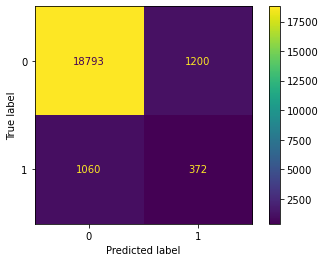

In [37]:
plot_confusion_matrix(model2, test, target_test)
plt.show()

In [38]:
predicted = model2.predict(test)
matrix = confusion_matrix(target_test, predicted)
acc = round(np.diag(matrix).sum()/matrix.sum(),4)
acc

0.8945

A acurácia subiu e fica em torno de 89.45%, o que é significativo dado o número maior de clientes testados, mas os falsos positivos e falsos negativos continuam muito maiores que o número de acertos ao prever inadimplentes.

É possível que o modelo se torne mais preciso se remover-mos alguma coluna. Irei testar a performance do modelo removendo cada coluna, uma por vez.

In [40]:
precision=[]
for col in train_data_no_salary.columns:
    if col == "inadimplente":
        continue
    train_data_iter = train_data_no_salary.drop(col, axis = 1)
    train, test, target_train, target_test = train_test_split(
        train_data_iter.drop("inadimplente", axis = 1),
        train_data_iter["inadimplente"],
        test_size = 0.2,
        random_state = 33
    )
    model3 = DecisionTreeClassifier()
    model3 = model3.fit(train, target_train)
    predicted = model3.predict(test)
    matrix = confusion_matrix(target_test, predicted)
    precision.append(round(matrix[1,1]/sum(matrix[1,:]),4))
    
precision

[0.2402, 0.2395, 0.2388, 0.2437, 0.2416, 0.2472, 0.2654, 0.243, 0.2577]

A lista acima representa o número de acertos do modelo dividido pelo número total (acertos mais erros) ao prever inadimplentes. Cada valor da lista está associado à remoção de uma das colunas. Os valores mais relevantes são os associados a remoção do número de empréstimos e do número de dependentes da base de dados. Vale a pena investigar mais atentamente a performance do modelo nessas condições.

Irei remover primeiramente a coluna *numero_de_dependentes* pois assim eu posso aproveitar todos os clientes do banco de dados original, dando mais informação para o modelo treinar.

<function matplotlib.pyplot.show(close=None, block=None)>

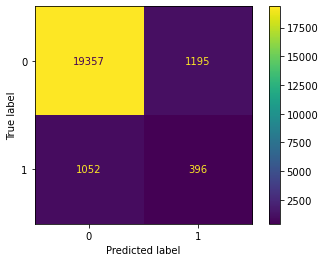

In [59]:
train_data_no_dep = train_data.drop(["numero_de_dependentes","salario_mensal"], axis = 1)
train, test, target_train, target_test = train_test_split(
    train_data_no_dep.drop("inadimplente", axis = 1),
    train_data_no_dep["inadimplente"],
    test_size = 0.2,
    random_state = 33
)
model4 = DecisionTreeClassifier()
model4 = model4.fit(train, target_train)
predicted = model4.predict(test)
matrix = confusion_matrix(target_test, predicted)

plot_confusion_matrix(model4,test,target_test)
plt.show

In [60]:
acc = round(np.diag(matrix).sum()/matrix.sum(),4)
acc

0.8979

O modelo agora possui uma acurácia em torno de 89.7% e a matriz de confusão está melhor que a anterior. Podemos testar a remoção de mais uma coluna. Outra coluna que parece influenciar pouco o resultado é a de empréstimos imobiliarios. Vamos ver como o modelo se sai removendo também essa coluna

<function matplotlib.pyplot.show(close=None, block=None)>

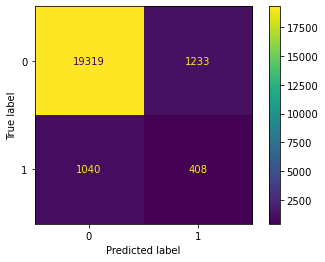

In [68]:
train_data_no_re = train_data_no_dep.drop("numero_emprestimos_imobiliarios", axis = 1)
train, test, target_train, target_test = train_test_split(
    train_data_no_re.drop("inadimplente", axis = 1),
    train_data_no_re["inadimplente"],
    test_size = 0.2,
    random_state = 33
)
model5 = DecisionTreeClassifier()
model5 = model5.fit(train, target_train)
predicted = model5.predict(test)
matrix = confusion_matrix(target_test, predicted)

plot_confusion_matrix(model5,test,target_test)
plt.show

In [69]:
acc = round(np.diag(matrix).sum()/matrix.sum(),4)
acc

0.8967

In [ ]:
train_data_no_dep

Desta vez a acurácia do modelo caiu. Remover o numero de empréstimos prejudica o aprendizado do modelo. O modelo número 4 provavelmente é o melhor possível seguindo nessa estratégia. Para confirmar, irei novamente calcular a acurácia removendo uma coluna por vez

In [72]:
acc_list=[]
for col in train_data_no_dep.columns:
    if col == "inadimplente":
        continue
    train_data_iter = train_data_no_dep.drop(col, axis = 1)
    train, test, target_train, target_test = train_test_split(
        train_data_iter.drop("inadimplente", axis = 1),
        train_data_iter["inadimplente"],
        test_size = 0.2,
        random_state = 33
    )
    model = DecisionTreeClassifier()
    model = model.fit(train, target_train)
    predicted = model.predict(test)
    matrix = confusion_matrix(target_test, predicted)
    acc_list.append(round(np.diag(matrix).sum()/matrix.sum(),4))
    
acc_list

[0.8979, 0.9015, 0.8935, 0.9039, 0.8995, 0.8949, 0.8956, 0.8968]

Dois valores da lista passam dos 90% na maioria dos testes, representando a remoção das colunas *idade* e *razao_debito*. irei calcular a matriz removendo cada uma delas, e mais um removendo as duas.

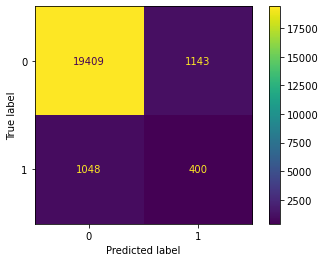

In [75]:
train_data_no_age = train_data_no_dep.drop("idade", axis = 1)
train, test, target_train, target_test = train_test_split(
    train_data_no_age.drop("inadimplente", axis = 1),
    train_data_no_age["inadimplente"],
    test_size = 0.2,
    random_state = 33
)
model61 = DecisionTreeClassifier()
model61 = model61.fit(train, target_train)
predicted = model61.predict(test)
matrix = confusion_matrix(target_test, predicted)

plot_confusion_matrix(model61,test,target_test)
plt.show

acc_model6 = []
acc_model6.append(round(np.diag(matrix).sum()/matrix.sum(),4))

<function matplotlib.pyplot.show(close=None, block=None)>

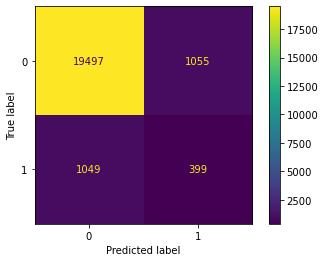

In [76]:
train_data_no_rd = train_data_no_dep.drop("razao_debito", axis = 1)
train, test, target_train, target_test = train_test_split(
    train_data_no_rd.drop("inadimplente", axis = 1),
    train_data_no_rd["inadimplente"],
    test_size = 0.2,
    random_state = 33
)
model62 = DecisionTreeClassifier()
model62 = model62.fit(train, target_train)
predicted = model62.predict(test)
matrix = confusion_matrix(target_test, predicted)
acc_model6.append(round(np.diag(matrix).sum()/matrix.sum(),4))
plot_confusion_matrix(model62,test,target_test)
plt.show

[0.9004, 0.9044, 0.9028]

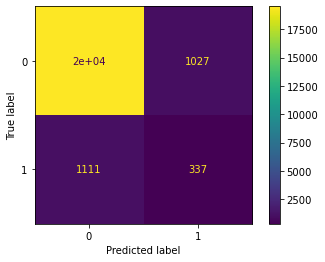

In [77]:
train_data_last = train_data_no_age.drop("razao_debito", axis = 1)
train, test, target_train, target_test = train_test_split(
    train_data_last.drop("inadimplente", axis = 1),
    train_data_last["inadimplente"],
    test_size = 0.2,
    random_state = 33
)
model63 = DecisionTreeClassifier()
model63 = model63.fit(train, target_train)
predicted = model63.predict(test)
matrix = confusion_matrix(target_test, predicted)
acc_model6.append(round(np.diag(matrix).sum()/matrix.sum(),4))
plot_confusion_matrix(model63,test,target_test)
plt.show
acc_model6

**Remover a coluna *razao_debito* (alem das outras duas) forneceu o melhor resultado.**

---

## Recapitulando

A forma com a qual eu propuz melhorar a análise dos dados foi removendo colunas com informação que não ajuda o aprendizado do modelo de arvore de decisão. Ao todo as colunas removidas foram a do salário, a da razão entre dívidas e patrimônio e a do número de dependentes. Fazer essas alterações elevaram a acurácia do modelo de 89.2% para 90.4%.

---

## Aplicando o modelo a um novo conjunto de dados

A etapa final deste case técnico é aplicar o modelo treinado a um novo banco de dados.

In [78]:
test_data = pd.read_csv("teste.csv")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   util_linhas_inseguras                  40000 non-null  float64
 1   idade                                  40000 non-null  int64  
 2   vezes_passou_de_30_59_dias             40000 non-null  int64  
 3   razao_debito                           40000 non-null  float64
 4   salario_mensal                         32032 non-null  float64
 5   numero_linhas_crdto_aberto             40000 non-null  int64  
 6   numero_vezes_passou_90_dias            40000 non-null  int64  
 7   numero_emprestimos_imobiliarios        40000 non-null  int64  
 8   numero_de_vezes_que_passou_60_89_dias  40000 non-null  int64  
 9   numero_de_dependentes                  38954 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 3.1 MB


**Vamos pré-peprarar os dados e deletar as mesmas colunas que deletamos no treino.**

In [79]:
test_data["numero_de_vezes_que_passou_60_89_dias"]=test_data["numero_de_vezes_que_passou_60_89_dias"]-test_data["numero_vezes_passou_90_dias"]
test_data["vezes_passou_de_30_59_dias"]=test_data["vezes_passou_de_30_59_dias"]-test_data["numero_de_vezes_que_passou_60_89_dias"]

In [80]:
test_data_ready = test_data.drop(["salario_mensal","numero_de_dependentes","razao_debito"], axis = 1)

In [81]:
test_data_ready

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias
0,0.025849,62,0,3,0,2,0
1,0.667083,55,0,3,0,0,0
2,0.007093,44,0,20,0,1,0
3,0.091213,54,-1,15,0,1,1
4,0.112680,54,0,3,0,0,0
...,...,...,...,...,...,...,...
39995,0.000000,68,2,9,1,0,-1
39996,0.061117,84,0,7,0,0,0
39997,0.817745,70,0,17,0,2,0
39998,0.106139,64,2,12,0,4,0


**Com os dados prontos, vamos aplicar o melhor modelo obitido nas etapas anteriores (model62) e predizer quais desses clientes se tornarão inadimplentes**

In [85]:
predicted = model62.predict(test_data_ready)

In [86]:
predicted

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

**Por fim vamos unir essa previsão aos dados de teste em um unico arquivo csv**

In [87]:
predicted_df = pd.DataFrame(predicted.T, columns = ['inadimplente'])

In [88]:
final_df = pd.concat([predicted_df, test_data], axis = 1)
final_df

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0,0.091213,54,-1,0.351635,5900.0,15,0,1,1,0.0
4,0,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0.000000,68,2,0.062858,10833.0,9,1,0,-1,0.0
39996,0,0.061117,84,0,0.013598,8456.0,7,0,0,0,0.0
39997,1,0.817745,70,0,0.663056,6000.0,17,0,2,0,0.0
39998,0,0.106139,64,2,0.865438,5045.0,12,0,4,0,0.0


In [90]:
final_csv = final_df.to_csv(index=False, sep = ',')
with open(file = 'teste_completo.csv', mode = 'w', encoding = 'utf8',newline = '\n') as file:
    file.write(final_csv)